# YOLO object detection with OpenCV

We’ll learn how to use the YOLO object detector to detect objects in images.

The COCO dataset consists of 80 labels, including, but not limited to:

People
Bicycles
Cars and trucks
Airplanes
Stop signs and fire hydrants
Animals, including cats, dogs, birds, horses, cows, and sheep, to name a few
Kitchen and dining objects, such as wine glasses, cups, forks, knives, spoons, etc.
…and much more!
You can find a full list of what YOLO trained on the COCO dataset can detect using this link. https://github.com/pjreddie/darknet/blob/master/data/coco.names

![alt text](https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/opencv-yolo/yolo_car_chase_01_output.gif "")

In [14]:
import numpy as np
import argparse
import time
import cv2
import os
from pyimagesearch.imageutils import display

In [15]:
args = {}
args["yolo"] = "downloads/models-cia/yolo-coco" #"base path to YOLO directory"
args["confidence"] = 0.5
args["threshold"] = 0.3

images = [
	"images/yolo/baggage_claim.jpg",
	"images/yolo/dining_table.jpg",
	"images/yolo/living_room.jpg",
	"images/yolo/soccer.jpg",
]

# load the COCO class labels that our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
print(LABELS)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [16]:
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# determine only the *output* layer names that we need from YOLO
# The YOLO model is trained via the Darknet framework. We need to explicitly supply the output layer names 
# into the call to “.forward()”. It’s a requirement when using Darknet models with OpenCV.
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

[INFO] loading YOLO from disk...


[INFO] YOLO took 0.278247 seconds
[INFO] YOLO took 0.146967 seconds
[INFO] YOLO took 0.148529 seconds
[INFO] YOLO took 0.152857 seconds


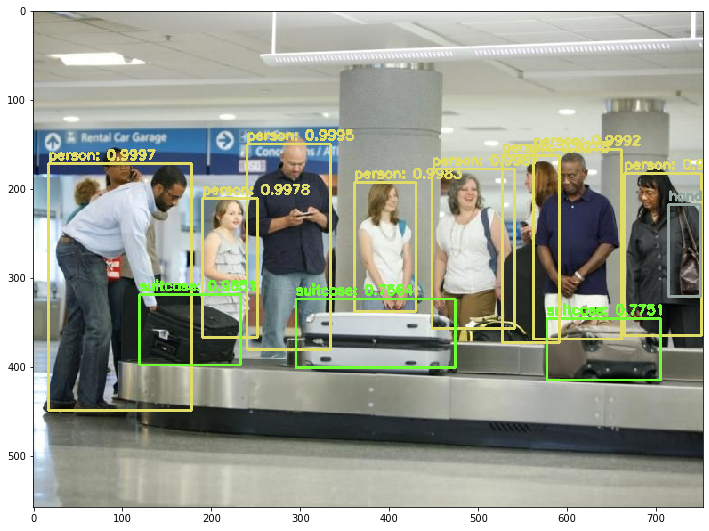

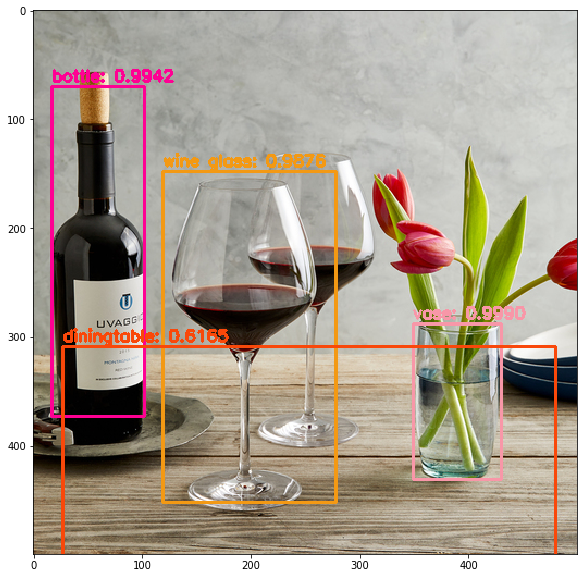

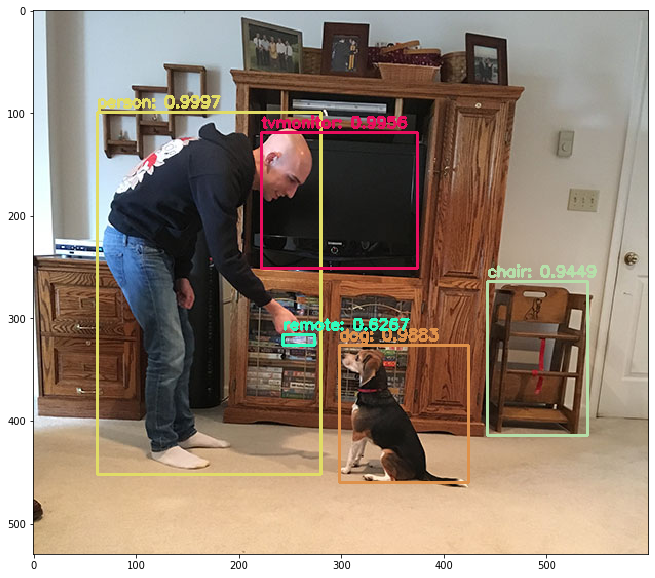

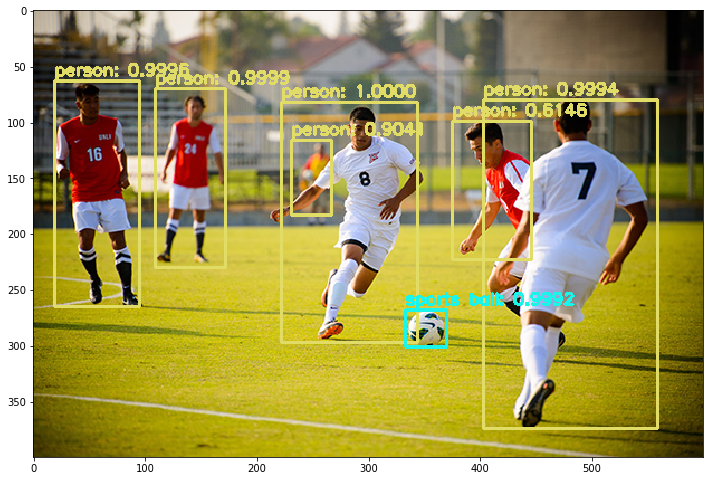

In [17]:
for img in images:
	# load our input image and grab its spatial dimensions
	image = cv2.imread(img)
	(H, W) = image.shape[:2]
	# construct a blob from the input image and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes and
	# associated probabilities
	blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	layerOutputs = net.forward(ln)
	end = time.time()

	# show timing information on YOLO
	print("[INFO] YOLO took {:.6f} seconds".format(end - start))

	# initialize our lists of detected bounding boxes, confidences, and
	# class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability) of
			# the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > args["confidence"]:
				# scale the bounding box coordinates back relative to the
				# size of the image, keeping in mind that YOLO actually
				# returns the center (x, y)-coordinates of the bounding
				# box followed by the boxes' width and height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top and
				# and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates, confidences,
				# and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)

	# apply non-maxima suppression to suppress weak, overlapping bounding
	# boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],args["threshold"])

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# draw a bounding box rectangle and label on the image
			color = [int(c) for c in COLORS[classIDs[i]]]
			cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
			cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
				0.5, color, 2)

	display(image)